<h1 style="text-align:center;"><b>Laboratorio 6</b></h1>
<h3 style="text-align:center;">Alina Carías (22539), Ariela Mishaan (22052), Marcos Díaz (221102) </h3>

# Librerías

In [ ]:
#import sys
#!{sys.executable} -m pip install --user "python-louvain"

In [5]:
import pandas as pd
import json
import unicodedata
import string
import nltk
import re
from nltk.corpus import stopwords
from collections import Counter

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import networkx as nx
import random

import community as community_louvain 
import collections
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from itertools import count


# ----- Análisis de tópicos con LDA (sklearn) -----
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 1. Carga de datos

## Tweets

In [6]:
with open("lab - datos redes/tioberny.txt", "r", encoding="utf-16") as f:
    tweetstxt = [json.loads(line) for line in f]

data = []
for t in tweetstxt:
    data.append({
        #"id": t.get("id"),
        "fecha": t.get("date"),
        "usuario": t["user"]["username"] if "user" in t else None,
        "nombre": t["user"]["displayname"] if "user" in t else None,
        "texto": t.get("rawContent"),
        "likes": t.get("likeCount"),
        "hashtags": t.get("hashtags"),
        #"mentioned": t.get("mentionedUsers"),
        "viewcount": t.get("viewCount"),
        "retweets": t.get("retweetCount"),
        "replies": t.get("replyCount"),
        "quotes": t.get("quoteCount")
        #"url": t.get("url")
    })

tweets = pd.DataFrame(data)
tweets.head()

fecha         usuario                  nombre  \
0  2024-09-12 17:21:03+00:00  La_ReVoluZzion      The_ReVoluZZzioN 🫡   
1  2024-09-12 15:27:20+00:00      XelaNewsGt                XelaNews   
2  2024-09-12 17:20:25+00:00       M24095273  VIVAlafuenteDEtodaVIDA   
3  2024-09-12 17:18:48+00:00    carlosalbesc  Carlos Alberto Escobar   
4  2024-09-12 17:16:42+00:00      Brenda_AGN             Brenda Lari   

                                               texto  likes  \
0  _\nConfirmado Compañeres,\n\nEl impuesto por l...      0   
1  #URGENTE Lo que los medios #faferos no informa...    142   
2  @IvanDuque @BArevalodeLeon Con que usaste PEGA...      0   
3  @IvanDuque @BArevalodeLeon Entre Ellos se enti...      0   
4  El presidente @BArevalodeLeon y la vicepreside...      0   

                                            hashtags  viewcount  retweets  \
0                                                 []        NaN         0   
1  [URGENTE, faferos, BernardoArévalo, NebajQuich...     5200.0        80   
2                                                 []        NaN         0   
3                                                 []        NaN         0   
4                                                 []        7.0         0   

   replies  quotes  
0        0       0  
1       12      15  
2        0       0  
3        0       0  
4        0       0

## Usuarios

In [7]:
user_data = {}
for t in tweetstxt:
    if "user" in t:
        u = t["user"]
        user_data[u["id"]] = {
            #"usuario_id": u["id"],
            "username": u.get("username"),
            "nombre": u.get("displayname"),
            "descripcion": u.get("rawDescription"),
            "creado_en": u.get("created"),
            "followers": u.get("followersCount"),
            "friends": u.get("friendsCount"),
            "tweets_totales": u.get("statusesCount"),
            "favourites": u.get("favouritesCount"),
            #"location": u.get("location"),
            #"url": u.get("url"),
            #"verified": u.get("verified"),
            #"profile_image": u.get("profileImageUrl"),
            #"profile_banner": u.get("profileBannerUrl")
        }

df_users = pd.DataFrame(list(user_data.values()))
df_users.head()

username                  nombre  \
0  La_ReVoluZzion      The_ReVoluZZzioN 🫡   
1      XelaNewsGt                XelaNews   
2       M24095273  VIVAlafuenteDEtodaVIDA   
3    carlosalbesc  Carlos Alberto Escobar   
4      Brenda_AGN             Brenda Lari   

                                         descripcion  \
0  ¡Defensor de los defensores de los DDHH, PRO-L...   
1                          Noticias sin injerencias.   
2                                   CONCIENCIA TOTAL   
3                                                      
4                                                      

                   creado_en  followers  friends  tweets_totales  favourites  
0  2021-09-07 02:11:21+00:00       2102      531           51984      143089  
1  2018-01-25 22:11:34+00:00       3462      359            2915        5719  
2  2019-01-20 18:39:29+00:00         30      171             598         201  
3  2014-11-17 13:58:10+00:00         11      218            4302        2817  
4  2015-02-03 03:55:36+00:00        564      223            8707        4274

## Inspección inicial

In [8]:
tweets.info()
display(tweets.head())
tweets.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5019 entries, 0 to 5018
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   fecha      5019 non-null   object 
 1   usuario    5019 non-null   object 
 2   nombre     5019 non-null   object 
 3   texto      5019 non-null   object 
 4   likes      5019 non-null   int64  
 5   hashtags   5019 non-null   object 
 6   viewcount  4938 non-null   float64
 7   retweets   5019 non-null   int64  
 8   replies    5019 non-null   int64  
 9   quotes     5019 non-null   int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 392.2+ KB


fecha         usuario                  nombre  \
0  2024-09-12 17:21:03+00:00  La_ReVoluZzion      The_ReVoluZZzioN 🫡   
1  2024-09-12 15:27:20+00:00      XelaNewsGt                XelaNews   
2  2024-09-12 17:20:25+00:00       M24095273  VIVAlafuenteDEtodaVIDA   
3  2024-09-12 17:18:48+00:00    carlosalbesc  Carlos Alberto Escobar   
4  2024-09-12 17:16:42+00:00      Brenda_AGN             Brenda Lari   

                                               texto  likes  \
0  _\nConfirmado Compañeres,\n\nEl impuesto por l...      0   
1  #URGENTE Lo que los medios #faferos no informa...    142   
2  @IvanDuque @BArevalodeLeon Con que usaste PEGA...      0   
3  @IvanDuque @BArevalodeLeon Entre Ellos se enti...      0   
4  El presidente @BArevalodeLeon y la vicepreside...      0   

                                            hashtags  viewcount  retweets  \
0                                                 []        NaN         0   
1  [URGENTE, faferos, BernardoArévalo, NebajQuich...     5200.0        80   
2                                                 []        NaN         0   
3                                                 []        NaN         0   
4                                                 []        7.0         0   

   replies  quotes  
0        0       0  
1       12      15  
2        0       0  
3        0       0  
4        0       0

fecha         0
usuario       0
nombre        0
texto         0
likes         0
hashtags      0
viewcount    81
retweets      0
replies       0
quotes        0
dtype: int64

# 2. Limpieza y preprocesamiento

In [9]:
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

SPANISH_STOPWORDS = set(stopwords.words('spanish'))

In [10]:
# regex según acción por hacer
URL_RE = re.compile(r'https?://\S+|www\.\S+', re.IGNORECASE)
MENTION_RE = re.compile(r'@([A-Za-z0-9_]{1,15})')  # handle básico de X
HASHTAG_RE = re.compile(r'#(\w+)')
EMOJI_RE = re.compile(r'[\U00010000-\U0010ffff]', flags=re.UNICODE)

In [11]:
# funciones para parsear cada item de cada tweet. 
def normalize_username(u):
    if pd.isna(u):
        return u
    return str(u).strip().lower()

def clean_text(text: str):
    if pd.isna(text):
        return ''
    t = text
    t = URL_RE.sub(' ', t)
    t = EMOJI_RE.sub(' ', t)
    t = t.lower()
    t = unicodedata.normalize('NFKD', t)
    t = ''.join(ch for ch in t if not unicodedata.combining(ch))
    t = t.translate(str.maketrans('', '', string.punctuation))
    t = re.sub(r'\d+', ' ', t)
    tokens = [w for w in re.findall(r'\b\w+\b', t) if w not in SPANISH_STOPWORDS]
    return ' '.join(tokens)

# devuelve una lista de todas las menciones (@) encontradas en el tweet. 
def extract_mentions(text: str):
    return [m.lower() for m in MENTION_RE.findall(text or '')]

# devuelve una lista de todos los hashtags (#) encontradas en el tweet. 
def extract_hashtags(text: str):
    return [h.lower() for h in HASHTAG_RE.findall(text or '')]

# si empieza con "rt" lo marca como retweet. 
def is_retweet(text: str):
    return bool(re.match(r'^\s*rt\s*@', str(text).lower()))

# si empieza con "@usuario" lo marca como reply. 
def is_reply(text: str):
    return bool(re.match(r'^\s*@', str(text).lower()))

In [12]:
tweets['username'] = tweets['usuario'].map(normalize_username)
tweets['tweet_text_clean'] = tweets['texto'].map(clean_text)
tweets['mentions'] = tweets['texto'].map(extract_mentions)
tweets['hashtags'] = tweets['texto'].map(extract_hashtags)
tweets['is_retweet'] = tweets['texto'].map(is_retweet)
tweets['is_reply'] = tweets['texto'].map(is_reply)
tweets['fecha'] = pd.to_datetime(tweets['fecha'], errors='coerce')

# Eliminar duplicados por texto y usuario en el mismo instante
tweets = tweets.drop_duplicates(subset=['username','texto','fecha']).reset_index(drop=True)
display(tweets.head())

fecha         usuario                  nombre  \
0 2024-09-12 17:21:03+00:00  La_ReVoluZzion      The_ReVoluZZzioN 🫡   
1 2024-09-12 15:27:20+00:00      XelaNewsGt                XelaNews   
2 2024-09-12 17:20:25+00:00       M24095273  VIVAlafuenteDEtodaVIDA   
3 2024-09-12 17:18:48+00:00    carlosalbesc  Carlos Alberto Escobar   
4 2024-09-12 17:16:42+00:00      Brenda_AGN             Brenda Lari   

                                               texto  likes  \
0  _\nConfirmado Compañeres,\n\nEl impuesto por l...      0   
1  #URGENTE Lo que los medios #faferos no informa...    142   
2  @IvanDuque @BArevalodeLeon Con que usaste PEGA...      0   
3  @IvanDuque @BArevalodeLeon Entre Ellos se enti...      0   
4  El presidente @BArevalodeLeon y la vicepreside...      0   

                                            hashtags  viewcount  retweets  \
0                                                 []        NaN         0   
1  [urgente, faferos, bernardoarévalo, nebajquich...     5200.0        80   
2                                                 []        NaN         0   
3                                                 []        NaN         0   
4                                                 []        7.0         0   

   replies  quotes        username  \
0        0       0  la_revoluzzion   
1       12      15      xelanewsgt   
2        0       0       m24095273   
3        0       0    carlosalbesc   
4        0       0      brenda_agn   

                                    tweet_text_clean  \
0  confirmado companeres impuesto usembassyguate ...   
1  urgente medios faferos informaron ayer acerca ...   
2  ivanduque barevalodeleon usaste pegasus espiar...   
3  ivanduque barevalodeleon entienden bien si est...   
4  presidente barevalodeleon vicepresidenta karin...   

                                            mentions  is_retweet  is_reply  
0  [usembassyguate, 48cantonestoto, usaidguate, u...       False     False  
1                                                 []       False     False  
2                        [ivanduque, barevalodeleon]       False      True  
3                        [ivanduque, barevalodeleon]       False      True  
4  [barevalodeleon, karinherreravp, agn_noticias,...       False     False

In [13]:
pd.set_option("display.max_colwidth", None)
tweets[['texto', 'tweet_text_clean']].head(20)  

texto  \
0                                                                        _\nConfirmado Compañeres,\n\nEl impuesto por la @usembassyguate,\n—Solo cuenta con el pagado apoyo de los @48CantonesToto a través de la @USAIDGuate y @UEGuatemala\n\n@BArevalodeLeon huye y se esconde del Verdadero Pueblo Guatemalteco.   
1        #URGENTE Lo que los medios #faferos no informaron ayer, acerca de la visita del presidente #BernardoArévalo a #NebajQuiché, donde fue sacado a toda prisa por #SAAS ya que  manifestantes pedían ser escuchados por el mandatario, quien decidió huir de esta manera.\n#XelaNews 🇫🇷 https://t.co/UQQbnvlfTa   
2                                                                                                                           @IvanDuque @BArevalodeLeon Con que usaste PEGASUS para espiar a tus detractores! obra de un narcisista sin conciencia, buena pinta por fuera corazon negro y podrido por dentro sin alma   
3                                                                                                                                                                                                           @IvanDuque @BArevalodeLeon Entre Ellos se entienden bien, y sÍ están  cuadrando una "PRODUCTIVA"reunión.   
4                                                                 El presidente @BArevalodeLeon y la vicepresidenta @KarinHerreraVP  participan en la Sesión Solemne en Conmemoración del 203 Aniversario de la Independencia de la República de Guatemala.\n\n@AGN_noticias\n@CongresoGuate https://t.co/zw3c2EqgK7   
5                                                                                                                                                                                                                             @BArevalodeLeon El muy hijo de puta inyectó con enfermedades venereas a Guatemaltecos.   
6                                                                                                                                                                                                                                           @EmisorasUnidas @BArevalodeLeon Y que de bueno le trae a Guatemala eso??   
7                                                                                            @IvanDuque @BArevalodeLeon Productiva es que genere algo productivo y una charla sin nada que construya algo real no es para nada productivo, más bien es algo similar a unas viejas chismosas hablando de temas random   
8                                                                     @KarinHerreraVP El presidente de la República, @BArevalodeLeon, hace su ingreso al hemiciclo del Legislativo para participar en la sesión solemne en conmemoración de un aniversario más de la independencia del país. https://t.co/8x3ByTeAMN   
9                                                                                                                                                                        @mys_servicios @BArevalodeLeon No tampoco, ese izmierda también se cago en Guatemala o no se recuerdan de los experimentos en Guatemaltecos   
10                                                                                                                                                            Happening Now: President @BArevalodeLeon  participates in the Commemoration of the 203rd Anniversary of the Independence of the Republic of Guatemala.   
11                                                                                                                                  🔴 |  El presidente @BArevalodeLeon participa en la Sesión Solemne en Conmemoración del 203 Aniversario de la Independencia de la República de Guatemala. https://t.co/kNfJVSiW8c   
12                                                                                                            Ingreso del presidente @BArevalodeLeon al hemiciclo parlamentario para participar en la sesión solemne en conmemoración del 203 años de i

# 3. Análisis exploratorio (EDA)

In [14]:
num_tweets = len(tweets)
num_usuarios = tweets['username'].nunique()
num_menciones = tweets['mentions'].map(len).sum()
all_hashtags = [h for hs in tweets['hashtags'] for h in hs]
num_hashtags = len(all_hashtags)

print('Tweets:', num_tweets)
print('Usuarios únicos:', num_usuarios)
print('Total de menciones:', num_menciones)
print('Total de hashtags:', num_hashtags)

top_mentions = Counter([m for ms in tweets['mentions'] for m in ms]).most_common(10)
top_hashtags = Counter(all_hashtags).most_common(10)
print('\nTop menciones:', top_mentions)
print('Top hashtags:', top_hashtags)

Tweets: 4944
Usuarios únicos: 2620
Total de menciones: 17220
Total de hashtags: 390

Top menciones: [('barevalodeleon', 4793), ('guatemalagob', 912), ('ubaldomacu', 573), ('santipalomov', 524), ('mpguatemala', 466), ('fjimenezmingob', 403), ('mingobguate', 288), ('__vadertg', 272), ('congresoguate', 255), ('diariodeca', 219)]
Top hashtags: [('guatemalasaleadelante', 24), ('urgente', 17), ('minfinsaleadelante', 17), ('guatemala', 16), ('presupuesto2025', 14), ('unpresupuestoparalapoblación', 13), ('enelpaísdca', 12), ('nacionalesagn', 8), ('traficogt', 6), ('ahora', 6)]


El dataset tiene 4,944 tweets de 2,620 usuarios únicos, lo que indica que la mayoría de los usuarios solo publica 1 o 2 veces, mientras que unos pocos podrían ser muy activos. Con un total de 17,220 menciones, cada tweet menciona en promedio a 3–4 usuarios, lo que refleja un alto grado de interacción directa y conversación entre los participantes. En contraste, hay solo 390 hashtags, mostrando que los tweets dependen poco de hashtags para categorizarse o difundirse. En conjunto, la red es más rica en conexiones personales y debates que en difusión masiva basada en etiquetas, lo que sugiere que el análisis de menciones es clave para entender la estructura de comunidades.

## Nube de top palabras

In [15]:
mentions_flat = [m for ms in tweets['mentions'] for m in ms]
top_mentions = [m for m, _ in Counter(mentions_flat).most_common(10)]

custom_stopwords = set(STOPWORDS) | set(top_mentions) | {"si", "ma", "mas"} 
text_for_wc = ' '.join(tweets['tweet_text_clean'].tolist())

In [16]:
wc = WordCloud(
    width=900,
    height=400,
    background_color='white',
    stopwords=custom_stopwords
).generate(text_for_wc)
plt.figure(figsize=(10, 4))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras de tweets limpios')
plt.show()

In [17]:
frecuencias = wc.words_
print(type(frecuencias))
print(list(frecuencias.items())[:10])

<class 'dict'>
[('presidente', 1.0), ('gobierno', 0.924924924924925), ('solo', 0.9129129129129129), ('corrupto', 0.6906906906906907), ('vadertg', 0.6546546546546547), ('guatemala', 0.6396396396396397), ('usaidguate', 0.6306306306306306), ('asi', 0.5495495495495496), ('vos', 0.5405405405405406), ('pais', 0.5375375375375375)]


## Preguntas

### ¿Qué hashtags dominan la conversación?

In [18]:
all_hashtags = [h for hs in tweets['hashtags'] for h in hs]
hashtag_counts = Counter(all_hashtags)

In [19]:
wc_hashtags = WordCloud(
    width=900,
    height=400,
    background_color='white',
    colormap='inferno' 
).generate_from_frequencies(hashtag_counts)
plt.figure(figsize=(10, 4))
plt.imshow(wc_hashtags, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras de hashtags')
plt.show()

Los hashtags más comunes son "guatemalasaleadelante", "unpresupuestoparalapoblación", "minfinsaleadelante", "presupuesto2025", "urgente". Esto muestra que hay varios temas en tendencia, por ejemplo el presupuesto del gobierno para 2025. Los hashtags de "saleadelante" indican un sentimiento de optimismo en los tweets. También se ven temas como "golpedeeestado", o "golpistas", "renuncia", lo cual indica poca satisfacción con el gobierno actual. 

### ¿Cuáles son las cuentas más mencionadas?

In [20]:
all_mentions = [m for ms in tweets['mentions'] for m in ms]
mention_counts = Counter(all_mentions)

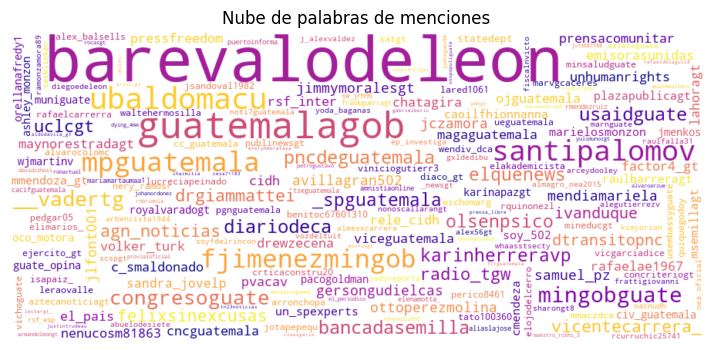

In [21]:
wc_mentions = WordCloud(
    width=900,
    height=400,
    background_color='white',
    colormap='plasma'  
).generate_from_frequencies(mention_counts)
plt.figure(figsize=(10, 4))
plt.imshow(wc_mentions, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras de menciones')
plt.show()

Las cuentas más mencinadas son las de Bernardo Arévalo y la cuenta oficial del gobierno. Luego hay otras, como "fjimenezmingob" (Francisco Jiménez), es el ministro de gobernación. También se menciona mucho la cuenta "santipalomov", de Santiago Palomo, el secretario de la Secretaría de Comunicación Social. Se pueden ver varias cuentas oficiales de instituciones, como "usaidguatemala", o "pncdeguatemala". 

### ¿Qué horarios concentran mpas actividad segun `tiempo_de_publicado`?

In [22]:
activity = (
    tweets.dropna(subset=['fecha'])
    .assign(hour=lambda d: d['fecha'].dt.hour)
    .groupby('hour')['texto']
    .count()
    .reset_index(name='tweets')
)
activity

hour  tweets
0      0     301
1      1     261
2      2     226
3      3     186
4      4     165
5      5     143
6      6      89
7      7      33
8      8      17
9      9      13
10    10      42
11    11     104
12    12     207
13    13     252
14    14     299
15    15     263
16    16     283
17    17     340
18    18     295
19    19     291
20    20     295
21    21     244
22    22     293
23    23     302

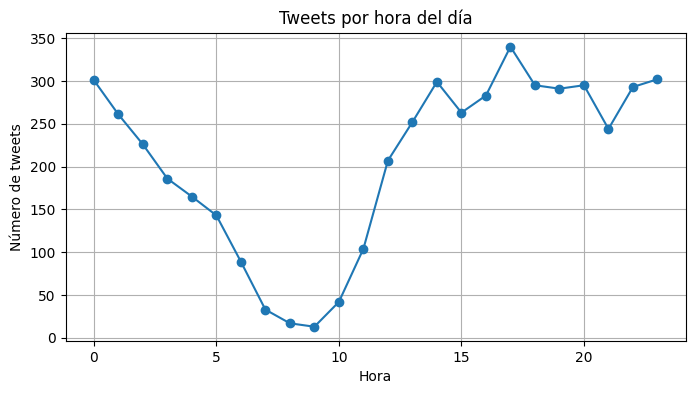

In [23]:
plt.figure(figsize=(8,4))
plt.plot(activity['hour'], activity['tweets'], marker='o')
plt.title('Tweets por hora del día')
plt.xlabel('Hora')
plt.ylabel('Número de tweets')
plt.grid(True)
plt.show()

Los horaros más populares para publicar tweets relacionados al gobierno de Guatemala y al presidente son a partir de las 14 horas. Esto podría indicar que las personas después de trabajar, o en el horario del almuerzo, son más activas en redes sociales. La actividad se mantiene relativamente constante desde las 16 horas (después del trabajo) hasta las 0h, cuando probablemente la gente se va a dormir y cada vez hay menos publicaciones. Las publicaciones empiezan a aumentar alrededor de las 9 de la mañana. 

### ¿Cuáles son los tweets con más retweets?

In [24]:
top10 = (tweets.sort_values('retweets', ascending=False)
            .loc[:, ['tweet_text_clean','retweets']]
            .head(10))

with pd.option_context('display.max_colwidth', None):
    display(
        top10.style.set_properties(
            **{'white-space': 'pre-wrap',
            'text-align': 'left'}
        , subset=['tweet_text_clean'])
    )


Se puede ver que los tweets más reposteados son comentarios políticos. El primero y el tercero tiene que ver con el presupuesto nacional. Los tweets no se limitan a la sitaución guatemalteca, sino también hay comentarios referentes a Milei de Argentina, o Bukele de el Salvador. 

# 4. Construcción de la red dirigida

In [25]:
rows = [] # tuplas (source, target, type)
for _, r in tweets.iterrows():
    user = r['username']
    # Retweet: RT @alguien: ...  interpretamos como user -> alguien (tipo retweet)
    if r['is_retweet']:
        ms = extract_mentions(r['tweet'])
        if ms:
            rows.append((user, ms[0], 'retweet'))
    # Reply: si inicia con @alguien  interpretamos como user -> alguien (tipo reply)
    if r['is_reply']:
        ms = extract_mentions(r['texto'])
        if ms:
            rows.append((user, ms[0], 'reply'))
    # Mentions: todas las menciones (pueden coexistir con RT/reply)
    for m in r['mentions']:
        rows.append((user, m, 'mention'))

edges = pd.DataFrame(rows, columns=['source','target','type'])
edges = edges[edges['source'] != edges['target']].drop_duplicates().reset_index(drop=True)
edges.head()

source          target     type
0  la_revoluzzion  usembassyguate  mention
1  la_revoluzzion  48cantonestoto  mention
2  la_revoluzzion      usaidguate  mention
3  la_revoluzzion     ueguatemala  mention
4  la_revoluzzion  barevalodeleon  mention

# 5. Topología

## Métricas

In [26]:
# armamos un grafo (de pandas dataframe (aristas) a grafo DIRIGIDO)
G = nx.from_pandas_edgelist(
    edges, source='source', target='target', create_using=nx.DiGraph()
)

print('Nodos:', G.number_of_nodes())
print('Aristas:', G.number_of_edges())

# Densidad
density = nx.density(G)
print('Densidad:', density)

# Diámetro: sobre el componente más grande (no definido si el grafo es disconexo)
if G.number_of_nodes() > 0:
    GCC_nodes = max(nx.weakly_connected_components(G), key=len)
    Gcc = G.subgraph(GCC_nodes).to_undirected()
    try:
        diameter = nx.diameter(Gcc)
    except nx.NetworkXError:
        diameter = np.nan
else:
    diameter = np.nan
print('Diámetro (componente mayor):', diameter)

# Coeficiente de agrupamiento (usamos versión no dirigida)
clustering = nx.average_clustering(G.to_undirected()) if G.number_of_nodes() > 0 else np.nan
print('Coeficiente de agrupamiento promedio:', clustering)

Nodos: 3115
Aristas: 12243
Densidad: 0.0012621506354051654
Diámetro (componente mayor): 6
Coeficiente de agrupamiento promedio: 0.3693694753822323


El grafo tiene 3,115 nodos y 12,243 aristas, lo que indica que hay muchos usuarios conectados, pero cada uno está vinculado a relativamente pocos otros. La densidad de la red es muy baja (0.00126), lo que refleja que solo una pequeña fracción de todas las posibles conexiones entre usuarios existe; esto es común en redes sociales, donde la mayoría de usuarios interactúa con unos pocos contactos directos.  

El diámetro del componente mayor es 6, lo que significa que cualquier usuario puede llegar a otro en máximo seis pasos; esto muestra que, a pesar de la baja densidad, la red está relativamente bien conectada y la información puede difundirse con rapidez. Finalmente, el coeficiente de agrupamiento promedio es 0.37, indicando que los usuarios tienden a formar grupos locales o comunidades cerradas, donde los amigos de un usuario también suelen estar conectados entre sí, lo que refleja la presencia de subgrupos temáticos o de interacción frecuente dentro de la red.

## Visualizaciones

/var/folders/p9/c7lshh9n1j55x6_b26v_sx1h0000gn/T/ipykernel_70071/413615682.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', np.unique(colors).size)


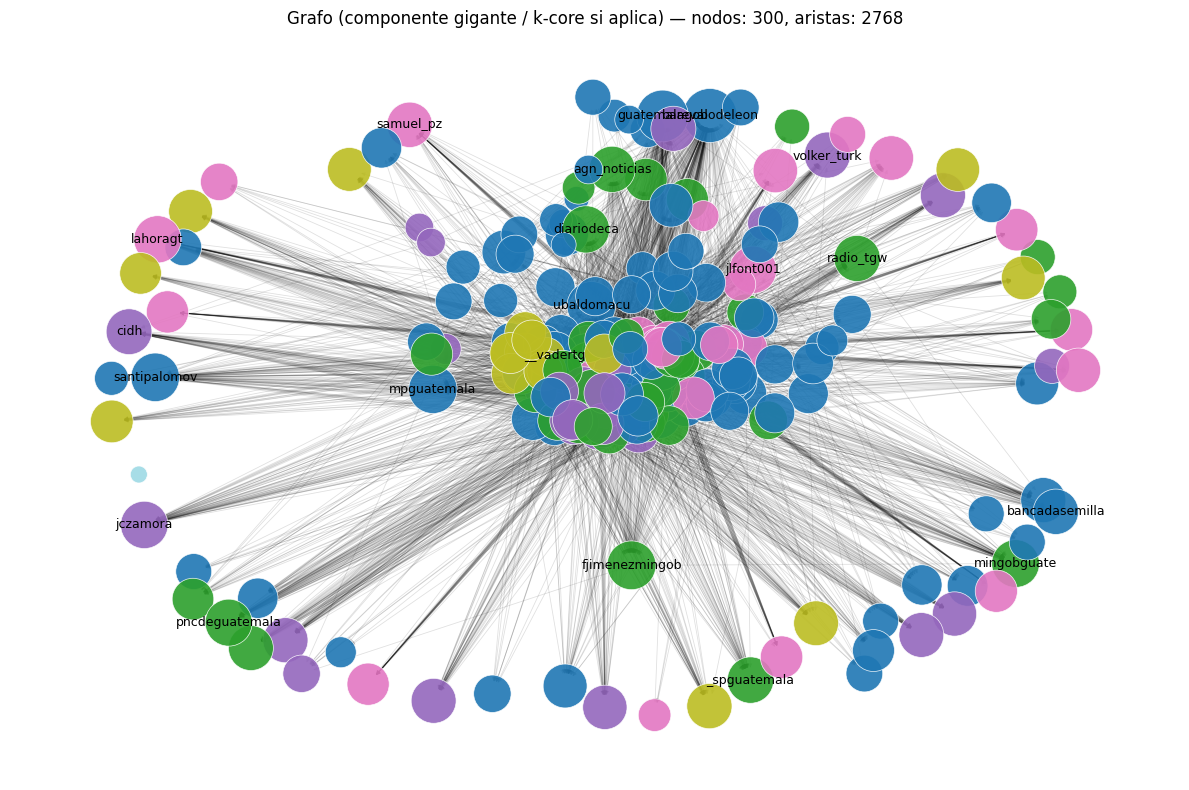

In [27]:
def plot_graph_pretty(G,
                    max_nodes=300,       
                    label_top=20,        
                    arrows=True,
                    seed=42):
    if G.number_of_nodes() == 0:
        print("Grafo vacío.")
        return
    GCC_nodes = max(nx.weakly_connected_components(G), key=len) if G.is_directed() \
                else max(nx.connected_components(G), key=len)
    H = G.subgraph(GCC_nodes).copy()

    H_und = H.to_undirected()
    n = H.number_of_nodes()
    if n > max_nodes:
        degrees = [d for _, d in H_und.degree()]
        k_max = int(np.percentile(degrees, 85)) 
        k_candidates = list(range(max(1, k_max), 0, -1))
        Hk = None
        for k in k_candidates:
            K = nx.k_core(H_und, k)
            if K.number_of_nodes() <= max_nodes and K.number_of_nodes() > 0:
                Hk = K
                break
        if Hk is None:
            top_nodes = [n for n, _ in sorted(H_und.degree(), key=lambda x: x[1], reverse=True)[:max_nodes]]
            Hk = H_und.subgraph(top_nodes).copy()
        H = H.subgraph(Hk.nodes()).copy()

    try:
        comms = list(nx.algorithms.community.greedy_modularity_communities(H.to_undirected()))
        comm_map = {}
        for cid, cset in enumerate(comms):
            for u in cset:
                comm_map[u] = cid
        colors = [comm_map.get(u, 0) for u in H.nodes()]
    except Exception:
        colors = None

    k = 1/np.sqrt(max(1, H.number_of_nodes()))
    pos = nx.spring_layout(H, seed=seed, k=3*k)

    deg = dict(H.degree())
    node_sizes = np.array([deg[u] for u in H.nodes()], dtype=float)
    node_sizes = 150 + 250 * np.log1p(node_sizes)

    plt.figure(figsize=(12, 8))
    if colors is not None:
        cmap = plt.cm.get_cmap('tab20', np.unique(colors).size)
        nx.draw_networkx_nodes(H, pos,
                            node_size=node_sizes,
                            node_color=colors,
                            cmap=cmap,
                            alpha=0.9,
                            linewidths=0.5,
                            edgecolors='white')
    else:
        nx.draw_networkx_nodes(H, pos,
                            node_size=node_sizes,
                            alpha=0.9,
                            linewidths=0.5,
                            edgecolors='white')

    edge_alpha = 0.12 if H.number_of_edges() > 2000 else 0.25
    nx.draw_networkx_edges(H, pos,
                        arrows=H.is_directed() and arrows,
                        arrowstyle='-|>',
                        arrowsize=6,
                        width=0.6,
                        alpha=edge_alpha)

    top_label_nodes = set([n for n, _ in sorted(deg.items(), key=lambda x: x[1], reverse=True)[:label_top]])
    labels = {n: str(n) for n in H.nodes() if n in top_label_nodes}
    nx.draw_networkx_labels(H, pos, labels=labels, font_size=9)

    plt.title(f'Grafo (componente gigante / k-core si aplica) — nodos: {H.number_of_nodes()}, aristas: {H.number_of_edges()}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_graph_pretty(G, max_nodes=300, label_top=20)


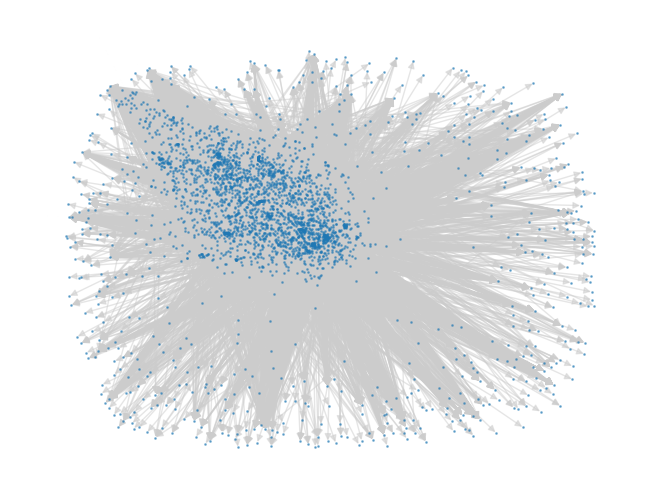

In [28]:
pos = nx.spring_layout(G, seed=42, iterations=10) 
nx.draw(G, pos, node_size=1, edge_color='#cccccc', alpha=0.5, with_labels=False)
plt.show()

# 6. Detección de comunidades

## Algoritmo escogido: Louvain

Escogimos el algoritmo Louvain porque es un algoritmo eficiente y ampliamente utilizado para detectar comunidades en grafos grandes. Funciona optimizando una métrica llamada modularidad, que mide la densidad de aristas dentro de comunidades comparada con lo que sería esperado al azar. Louvain es especialmente útil en redes sociales porque:

- Maneja redes grandes de manera rápida.
- Detecta automáticamente el número de comunidades, sin necesidad de definirlo a priori.
- Permite identificar subgrupos densamente conectados, lo cual es relevante para analizar interacción, temas y cohesión de los usuarios.

En nuestro análisis, aplicamos Louvain sobre la versión no dirigida del grafo de menciones para descubrir comunidades naturales dentro de la red, y luego caracterizamos cada comunidad según tamaño y patrones de interacción.

## Ejecución

In [29]:
try:
    import community.community_louvain as community_louvain
except ImportError:
    community_louvain = None
    print('Instala python-louvain: pip install python-louvain')
    
if community_louvain:
    # Louvain trabaja con grafo no dirigido por defecto
    undirected = G.to_undirected()
    partition = community_louvain.best_partition(undirected, random_state=42)
    nx.set_node_attributes(G, partition, 'community')
    # Tamaños por comunidad
    counter = collections.Counter(partition.values())
    comm_sizes = pd.DataFrame(counter.items(), columns=['community','size']).sort_values('size', ascending=False)
    display(comm_sizes)
else:
    partition = {}
    comm_sizes = pd.DataFrame(columns=['community','size'])

community  size
5           5   914
11         11   333
6           6   231
0           0   211
3           3   199
2           2   185
12         12   171
10         10   164
7           7   150
8           8   142
1           1   129
9          16   111
4           4    85
14         14    50
17         18    12
20         21     9
18         19     8
21          9     3
16         17     2
19         20     2
15         15     2
13         13     2

## Caracterización de las comunidades

### Tamaño

In [42]:
counter = collections.Counter(partition.values())
comm_sizes = pd.DataFrame(counter.items(), columns=['community','size']).sort_values('size', ascending=False)
display(comm_sizes.head(3))

community  size
5           5   914
11         11   333
6           6   231

### Interacciones

In [43]:
comm_metrics = []
for cid in comm_sizes.head(3)['community']:
    nodes_c = [n for n, c in partition.items() if c == cid]
    internal_edges = G.subgraph(nodes_c).number_of_edges()
    external_edges = sum(1 for u, v in G.edges() if (u in nodes_c) != (v in nodes_c))
    comm_metrics.append({'community': cid, 'size': len(nodes_c), 
                         'internal_edges': internal_edges, 'external_edges': external_edges})

comm_metrics_df = pd.DataFrame(comm_metrics)
display(comm_metrics_df)

community  size  internal_edges  external_edges
0          5   914            1475            2127
1         11   333             957            1060
2          6   231             442             959

- **Community 5 (914 nodos)**: Es la más grande, con 1,475 interacciones internas y 2,127 externas. Esto indica que aunque hay un núcleo denso de usuarios que interactúan entre sí, también hay muchas conexiones hacia otras comunidades, lo que sugiere que actúa como un puente entre grupos.
  
- **Community 11 (333 nodos)**: Tiene un tamaño intermedio, con 957 interacciones internas y 1,060 externas. Aquí se observa un equilibrio entre cohesión interna y conexiones externas, mostrando que los usuarios interactúan con frecuencia dentro del grupo pero también participan en la conversación de otros subgrupos.
  
- **Community 6 (231 nodos)**: La más pequeña de las tres, con 442 interacciones internas y 959 externas. Aunque tiene menos miembros y menos interacciones internas, su número de conexiones externas relativamente alto indica que este grupo influye fuera de su comunidad, posiblemente difundiendo información a otros grupos más grandes.

En resumen, el tamaño y la distribución de interacciones muestran una jerarquía de comunidades: la más grande funciona como núcleo central con gran conectividad externa, la intermedia es equilibrada y la pequeña tiene un rol más periférico pero con difusión significativa.

### Temas principales

In [ ]:

# --- obtener top 3 comunidades por tamaño ---
top_3_cids = comm_sizes.head(3)['community']

top_hashtags_per_comm = {}
top_mentions_per_comm = {}

for cid in top_3_cids:
    # nodos de esta comunidad
    nodes_c = [n for n, c in partition.items() if c == cid]
    
    # filtrar DataFrame de tweets para estos usuarios
    tweets_c = tweets[tweets['username'].isin(nodes_c)]
    
    # hashtags de la comunidad
    hashtags = [h.lower() for hs in tweets_c['hashtags'] for h in hs]
    top_hashtags_per_comm[cid] = Counter(hashtags).most_common(5)
    
    # menciones de la comunidad
    mentions = [m.lower() for ms in tweets_c['mentions'] for m in ms]
    top_mentions_per_comm[cid] = Counter(mentions).most_common(5)

# mostrar resultados
for cid in top_3_cids:
    print(f"\nComunidad {cid}:")
    print("Top hashtags:", top_hashtags_per_comm[cid])
    print("Top menciones:", top_mentions_per_comm[cid])


Comunidad 5:
Top hashtags: [('guatemala', 3), ('equipolh', 2), ('tiktok', 2), ('conadur', 2), ('sotf', 1)]
Top menciones: [('barevalodeleon', 1175), ('ivanduque', 122), ('olsenpsico', 105), ('gersongudielcas', 59), ('factor4_gt', 37)]

Comunidad 11:
Top hashtags: [('guatemala', 6), ('allanamientos', 1), ('mpfuerteyfirme', 1), ('casob410', 1), ('fortalecimientomp', 1)]
Top menciones: [('barevalodeleon', 751), ('ubaldomacu', 403), ('santipalomov', 378), ('mpguatemala', 324), ('guatemalagob', 76)]

Comunidad 6:
Top hashtags: [('guatemalasaleadelante', 22), ('minfinsaleadelante', 17), ('presupuesto2025', 13), ('unpresupuestoparalapoblación', 13), ('urgente', 4)]
Top menciones: [('barevalodeleon', 366), ('guatemalagob', 238), ('felixsinexcusas', 75), ('rafaelae1967', 52), ('maynorestradagt', 38)]


El análisis de las tres comunidades más grandes muestra patrones claros en torno a los temas y actores más mencionados. La Comunidad 5 se centra principalmente en Guatemala, con hashtags relacionados a medios o cuentas como ‘equipolh’ y ‘tiktok’, y menciona con gran frecuencia al presidente Bernardo Arévalo y a algunos usuarios con influencia moderada.  

La Comunidad 11 también tiene un enfoque geográfico y político, destacando hashtags como ‘allanamientos’ y referencias a instituciones públicas, con menciones concentradas en Arévalo y figuras vinculadas al gobierno y al MP.  

Por último, la Comunidad 6 muestra un marcado interés en temas de presupuesto y políticas públicas, como ‘presupuesto2025’ y ‘minfinsaleadelante’, y las menciones se enfocan tanto en Arévalo como en cuentas institucionales y de activismo.  

En conjunto, los hashtags y menciones reflejan que las comunidades no solo se estructuran por afinidad política y territorial, sino también por intereses temáticos específicos y la relevancia de ciertos usuarios dentro de cada grupo.

## Visualización

### Top 3

In [45]:
import matplotlib.cm as cm

# Tres comunidades más grandes
top_3 = comm_sizes.head(3)['community'].tolist()
nodes_top3 = [n for n, c in partition.items() if c in top_3]

# Subgrafo con solo estas comunidades
G_sub = G.subgraph(nodes_top3)

# Mapear colores solo a estas 3 comunidades
color_map_dict = {cid: color for cid, color in zip(top_3, ['red','green','blue'])}
node_color_map = [color_map_dict[partition[node]] for node in G_sub.nodes()]

# Layout
pos = nx.spring_layout(G_sub, k=0.5, iterations=50, seed=42)

plt.figure(figsize=(12,12))
nx.draw_networkx_nodes(G_sub, pos, node_color=node_color_map, node_size=150, alpha=0.8)
nx.draw_networkx_edges(G_sub, pos, alpha=0.3, width=0.5)
plt.axis('off')
plt.title("Top 3 comunidades más grandes", fontsize=16)
plt.show()

### Todas

In [40]:
import matplotlib.pyplot as plt
import networkx as nx
import community.community_louvain
import matplotlib.cm as cm
import numpy as np

# Grafo no dirigido para Louvain
undirected = G.to_undirected()
partition = community_louvain.best_partition(undirected, random_state=42)

# Colores automáticos según comunidad
num_communities = max(partition.values()) + 1
cmap = cm.get_cmap('tab20', num_communities)
node_color_map = [cmap(partition[node]) for node in G.nodes()]

# Layout
pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

plt.figure(figsize=(14, 14))
nx.draw_networkx_nodes(G, pos, node_color=node_color_map, node_size=150, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)
plt.axis('off')
plt.title("Comunidades detectadas por Louvain", fontsize=16)
plt.tight_layout()
plt.show()

/var/folders/p9/c7lshh9n1j55x6_b26v_sx1h0000gn/T/ipykernel_70071/3808703670.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_communities)


# 7. Influencers y nodos clave

In [31]:
import numpy as np
import pandas as pd
import networkx as nx

if G.number_of_nodes() > 0:
    # Centralidades para grafos dirigidos
    cent_degree   = nx.degree_centrality(G)          # combina in+out
    cent_in       = nx.in_degree_centrality(G)       # solo entrantes
    cent_out      = nx.out_degree_centrality(G)      # solo salientes
    cent_between  = nx.betweenness_centrality(G)     # intermediación
    cent_closeness= nx.closeness_centrality(G.to_undirected())  
    # (usamos versión no dirigida para evitar problemas de accesibilidad)

    centralities = (
        pd.DataFrame({
            'node': list(G.nodes()),
            'degree':     [cent_degree.get(n,0) for n in G.nodes()],
            'in_degree':  [cent_in.get(n,0) for n in G.nodes()],
            'out_degree': [cent_out.get(n,0) for n in G.nodes()],
            'betweenness':[cent_between.get(n,0) for n in G.nodes()],
            'closeness':  [cent_closeness.get(n,0) for n in G.nodes()],
            'community':  [G.nodes[n].get('community', np.nan) for n in G.nodes()]
        })
        .sort_values(['degree','betweenness','closeness'], ascending=False,
                    ignore_index=True)
    )

    display(centralities.head(10))
else:
    centralities = pd.DataFrame(columns=['node','degree','in_degree',
                                        'out_degree','betweenness',
                                        'closeness','community'])
    display(centralities)


node    degree  in_degree  out_degree  betweenness  closeness  \
0  barevalodeleon  0.809249   0.809249    0.000000     0.000000   0.836591   
1    guatemalagob  0.197816   0.197174    0.000642     0.000420   0.526573   
2      ubaldomacu  0.133911   0.130379    0.003532     0.013348   0.502362   
3    santipalomov  0.118497   0.118497    0.000000     0.000000   0.385878   
4     mpguatemala  0.107900   0.107579    0.000321     0.000131   0.381310   
5  fjimenezmingob  0.089917   0.089274    0.000642     0.000175   0.389867   
6       __vadertg  0.075466   0.068722    0.006744     0.004766   0.482528   
7   congresoguate  0.070328   0.070328    0.000000     0.000000   0.357709   
8     mingobguate  0.066474   0.066474    0.000000     0.000000   0.362915   
9      usaidguate  0.060694   0.060051    0.000642     0.000143   0.379066   

   community  
0          5  
1          6  
2         11  
3         11  
4         11  
5          0  
6          3  
7          3  
8          0  
9          3

La red analizada muestra una fuerte centralización en torno a *barevalodeleon*, quien destaca por recibir la mayoría de menciones (degree e in_degree de 0.809), sin emitir conexiones (out_degree = 0), y por estar estratégicamente ubicado (closeness de 0.83) dentro de la comunidad 5. Otros nodos relevantes como *guatemalagob*, *ubaldomacu* y *santipalomov* presentan grados intermedios y cierta capacidad de intermediación, aunque los valores de betweenness son bajos en general, lo que indica que la red no depende de nodos puente para su conectividad. Los actores están distribuidos en comunidades diferenciadas, reflejando agrupaciones temáticas o institucionales, pero todas giran en torno al nodo dominante, lo que sugiere una estructura jerárquica con un centro claramente definido.

# 8. Análisis de grupos aislados

## Componente gigante y subredes

In [48]:
# Componente gigante
if G.number_of_nodes() > 0:
    # weakly connected components (para grafos dirigidos)
    comps = list(nx.weakly_connected_components(G))
    comps_sorted = sorted(comps, key=len, reverse=True)
    
    giant = comps_sorted[0]
    others = comps_sorted[1:] if len(comps_sorted) > 1 else []
    
    # Información de componentes
    comp_rows = []
    for i, c in enumerate(comps_sorted):
        sub = G.subgraph(c).copy()
        density_ud = nx.density(sub.to_undirected()) if sub.number_of_nodes() > 1 else 0.0
        comp_rows.append({
            'component_id': i,
            'nodes': sub.number_of_nodes(),
            'edges': sub.number_of_edges(),
            'density_ud': density_ud,
            'is_giant': (i==0)
        })
    df_comps = pd.DataFrame(comp_rows).sort_values(['is_giant','nodes'], ascending=[False,False])
    print(f"Componentes débiles totales: {len(comps_sorted)} | Componente gigante: {len(giant)} nodos")
    display(df_comps)
else:
    df_comps = pd.DataFrame()
    print("Grafo vacío")

Componentes débiles totales: 6 | Componente gigante: 3104 nodos


component_id  nodes  edges  density_ud  is_giant
0             0   3104  12237    0.002515      True
1             1      3      2    0.666667     False
2             2      2      1    1.000000     False
3             3      2      1    1.000000     False
4             4      2      1    1.000000     False
5             5      2      1    1.000000     False

## Centralidades

In [49]:
# Solo sobre la componente gigante
H = G.subgraph(giant).copy()

# Centralidad de grado, intermediación y cercanía
degree_centrality = nx.degree_centrality(H)
betweenness_centrality = nx.betweenness_centrality(H)
closeness_centrality = nx.closeness_centrality(H)

## Detección de comunidades

In [50]:
if have_louvain:
    # Grafo no dirigido para Louvain
    undirected = H.to_undirected()
    partition = community_louvain.best_partition(undirected, random_state=42)
    nx.set_node_attributes(H, partition, 'community')
    
    # Tamaños de comunidades
    counter = Counter(partition.values())
    comm_sizes = pd.DataFrame(counter.items(), columns=['community','size']).sort_values('size', ascending=False)
    display(comm_sizes)
else:
    partition = {}
    comm_sizes = pd.DataFrame(columns=['community','size'])

community  size
4           4   941
11         12   353
0           0   292
3           3   199
2          11   187
7          15   180
8           8   173
1           1   164
6           6   153
10         10   144
5          13   134
12         16    79
9           9    68
14          2    12
16          7     9
13         14     8
15          5     8

## Métricas

In [51]:
def community_cut_stats(Gdir, partition_dict):
    rows = []
    comm2nodes = {}
    for n, c in partition_dict.items():
        comm2nodes.setdefault(c, set()).add(n)
    
    E = list(Gdir.edges())
    for cid, S in comm2nodes.items():
        if len(S)==0:
            continue
        S_out = set(Gdir.nodes()) - S
        internal = sum(1 for (u,v) in E if u in S and v in S)
        cut_out = sum(1 for (u,v) in E if u in S and v in S_out)
        cut_in  = sum(1 for (u,v) in E if u in S_out and v in S)
        boundary = cut_in + cut_out
        denom = 2*internal + boundary
        conductance = boundary/denom if denom>0 else 0.0
        external_ratio = boundary/(internal+boundary) if (internal+boundary)>0 else 0.0
        
        rows.append({
            'community': cid,
            'size': len(S),
            'internal_edges': internal,
            'boundary_edges': boundary,
            'cut_in': cut_in,
            'cut_out': cut_out,
            'external_ratio': external_ratio,
            'conductance': conductance
        })
    return pd.DataFrame(rows)

comm_stats = community_cut_stats(H, partition)
display(comm_stats.sort_values('size', ascending=False).head(10))

community  size  internal_edges  boundary_edges  cut_in  cut_out  \
4           4   941            1496            2096    1905      191   
11         12   353             956            1059     390      669   
0           0   292            1457            1365     757      608   
3           3   199             594             508     149      359   
2          11   187            1017             726     212      514   
7          15   180             618             629     205      424   
8           8   173             309             500     157      343   
1           1   164             277             427     126      301   
6           6   153             362             437     120      317   
10         10   144             268             425     178      247   

    external_ratio  conductance  
4         0.583519     0.411950  
11        0.525558     0.356446  
0         0.483700     0.319000  
3         0.460980     0.299528  
2         0.416523     0.263043  
7         0.504411     0.337265  
8         0.618047     0.447227  
1         0.606534     0.435270  
6         0.546934     0.376400  
10        0.613276     0.442248

## Unificación de todo

In [52]:
# Crear DataFrame por nodo
df_nodes = pd.DataFrame({
    'node': list(H.nodes()),
    'community': [partition.get(n, -1) for n in H.nodes()],
    'degree_centrality': [degree_centrality[n] for n in H.nodes()],
    'betweenness_centrality': [betweenness_centrality[n] for n in H.nodes()],
    'closeness_centrality': [closeness_centrality[n] for n in H.nodes()]
})

display(df_nodes.head(10))

node  community  degree_centrality  betweenness_centrality  \
0  la_revoluzzion          0           0.005801                0.000000   
1  usembassyguate          1           0.005479                0.000000   
2  48cantonestoto         11           0.000967                0.000000   
3      usaidguate          3           0.060909                0.000144   
4     ueguatemala          1           0.003867                0.000000   
5  barevalodeleon          4           0.812117                0.000000   
6       m24095273          4           0.000645                0.000000   
7       ivanduque          4           0.037705                0.000000   
8    carlosalbesc          4           0.000645                0.000000   
9      brenda_agn          0           0.001934                0.000028   

   closeness_centrality  
0              0.000000  
1              0.134962  
2              0.001031  
3              0.123815  
4              0.065619  
5              0.810521  
6              0.000000  
7              0.037383  
8              0.000000  
9              0.066435

## Explicación

La red analizada muestra una estructura claramente dominada por una componente gigante de 3104 nodos, mientras que los cinco subgrupos restantes son muy pequeños y densos internamente. Las métricas de centralidad revelan que ciertos usuarios actúan como hubs de información (grado), puentes entre comunidades (intermediación) y nodos estratégicos para la difusión rápida de contenido (cercanía). La ausencia de nodos aislados indica que todos los participantes están integrados en la dinámica de la red, aunque las subredes más pequeñas tienen un alcance limitado y su influencia se restringe a interacciones locales. En conjunto, la red refleja tanto la concentración de la actividad en usuarios centrales como la existencia de microgrupos densos que aportan cohesión interna sin afectar la propagación global de información.

- **Centralidad de grado (degree_centrality)**: mide cuántas conexiones tiene un nodo respecto al total posible. Por ejemplo, barevalodeleon tiene 0.812, lo que indica que está extremadamente conectado y probablemente actúa como un hub en la red. En contraste, nodos como la_revoluzzion o 48cantonestoto tienen valores muy bajos (<0.01), mostrando que están poco conectados.  

- **Centralidad de intermediación (betweenness_centrality)**: refleja cuántas veces un nodo se encuentra en los caminos más cortos entre otros nodos. Valores cercanos a cero (como la mayoría de tus nodos) indican que no sirven como puente entre subredes, mientras que nodos con valores altos actuarían como mediadores clave de información. Aquí, usaidguate tiene un valor ligeramente mayor (0.000144), pero todavía muy bajo en comparación con hubs reales.  
  
- **Centralidad de cercanía (closeness_centrality)**: indica qué tan cerca está un nodo de todos los demás en la red. Valores altos como el de barevalodeleon (0.810) muestran que puede difundir información rápidamente a toda la red, mientras nodos como la_revoluzzion (0) están aislados o en posiciones periféricas.

Estos datos permiten identificar usuarios influyentes (barevalodeleon) y usuarios periféricos con poca interacción. También se puede observar que los nodos con baja centralidad tienden a estar en comunidades pequeñas o con pocas interacciones, mientras que los hubs dominan comunidades grandes y conectadas. Esto es clave para entender la dinámica de información y posibles estrategias de difusión dentro de la red.

# 9. Análisis de Contenido y Sentimiento

## Análisis de sentimiento de los tweets (+/-/~)

## Identificación de temas principales de las redes 

## Relación de los temas con las comunidades detectadas

# 10. Interpretación y contexto

## ¿Cómo influyen los influencers y las comunidades en la formación de opiniones públicas?

## ¿Qué aceptación tenía Bernardo Arévalo como presidente de Guatemala en el año?

## ¿Cuál es la popularidad que tiene en estos momentos?

# Conclusiones